In [1]:
"""
Program Description:
This program reads in a csv file containing the information about the data to be plotted into the respective plots. 

Author:
- Heike Boehm, Department of Cellular Biophysics, MPI for Medical Research (MPImF-CBP-GS)
- With strong support from ChatGPT
- Idea and design for brick structure to enable comparision of different data sets by Florian Köhldorfer, MPImF-CBP-GS.

Input Data Sources:
- CSV Files generated by the "QCMD_flow_adj_to_bricks_folder" program.
- A csv file called "plotting.csv" that outlines which data should be plotted in which brick

Output Generated:
- Generated plots are saved as pdf files.
          
Comments on Coding:
- For all variables, lower_case_with_underscores are used.
- CapWords are used for class names (if applicable).
- UPPER_CASE_WITH_UNDERSCORES are used for constants.
"""


import os
import h5py
import ipywidgets as widgets
import seaborn as sns
import numpy as np
import ast
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time
from matplotlib.lines import Line2D  # Import Line2D


In [2]:
'''
Enter the path to the folder in which the adj_qcmd_bricks data is saved
'''

input_widget_width = '1000px'
description_width = '300px'

path_widget = widgets.Text(
    value="Processed_Data",
    description="Path to the folder containing your adj_qcmd_data:"
)

path = None

path_widget.layout.width = input_widget_width
path_widget.style.description_width = description_width

def save_path(sender):
    global path 
    path = path_widget.value

save_button = widgets.Button(description="Save")
save_button.on_click(save_path)

widgets.VBox([path_widget, save_button])


In [3]:
'''
Reads in the plotting.csv file in which all information regarding which data should be 
plotted in which way is saved. The program expects the csv file to contain the following
row titles with single or multiple values in each cell:
plot_no; persistentID; Title; bricks_to_plot; brick_titles; overtones_to_plot; brick_plot; 
delta_fVsDelta_D; Max_x
'''

def convert_to_list(string):
    # Split the string by commas
    elements = [x.strip() for x in string.split(',')]
    
    # Check if each element is an integer, and convert if possible
    return [int(x) if x.isdigit() else x for x in elements]

def convert_to_list_or_value(string):
    # Split the string by commas
    elements = [x.strip() for x in string.split(',')]

    # Check if there is only one element, return it as a single value
    if len(elements) == 1:
        return np.inf if elements[0].lower() == 'inf' else elements[0]

    # Check if each element is a special value, and convert if needed
    return [np.inf if x.lower() == 'inf' else x for x in elements]

def convert_overtones(string):
    # Split the string by commas and convert each element to an integer
    elements = [int(x) for x in string.split(',')]
    return elements[0] if len(elements) == 1 else elements

def read_plotting_task(path):
    file_path = os.path.join(path, "plotting.csv")

    try:
        # Read the CSV file and use custom functions for column conversion
        plotting_info = pd.read_csv(
            file_path,
            delimiter=';',
            converters={
                'bricks_to_plot': convert_to_list,
                'brick_titles': convert_to_list,
                'overtones_to_plot': convert_to_list
            }
        )
    except FileNotFoundError:
        print(f"Error: File 'plotting.csv' not found at {file_path}")
        return pd.DataFrame()  # Return an empty DataFrame if the file is not found
    except pd.errors.EmptyDataError:
        print(f"Error: 'plotting.csv' is empty")
        return pd.DataFrame()  # Return an empty DataFrame if the file is empty

    #display(plotting_info)
    return plotting_info



In [4]:
def plot_bricks(plotting_info, number_to_plot):
    all_bricks = []

    for persistentID, bricks_to_plot, plot_no, overtones_to_plot in zip(
        plotting_info['persistentID'],
        plotting_info['bricks_to_plot'],
        plotting_info['plot_no'],
        plotting_info['overtones_to_plot']
    ):
        
        # Check if the plot_no is equal to number_to_plot
        if plot_no != number_to_plot:
            continue

        try:
            file_to_read = os.path.join(path, f"Data_{persistentID}_adj_qcmd_bricks_data.csv")
            print(f"reading in Data_{persistentID}_adj_qcmd_bricks_data.csv")
        except FileNotFoundError:
            print(f"Error: File '{persistentID}_adj_qcmd_bricks_data.csv' not found at {file_path}")
            continue
        except pd.errors.EmptyDataError:
            print(f"Error: '{persistentID}_adj_qcmd_bricks_data.csv' is empty")
            continue

        adj_qcmd_bricks_data = pd.read_csv(file_to_read)
        
        adj_qcmd_bricks_data = adj_qcmd_bricks_data[
            (adj_qcmd_bricks_data['Overtone'].astype(int).isin(overtones_to_plot))
        ]

        adj_qcmd_bricks_data['brick_to_plot'] = [
            bricks_to_plot.index(brick) + 1 if brick in bricks_to_plot else np.nan
            for brick in adj_qcmd_bricks_data['Brick']
        ]

        adj_qcmd_bricks_data['persistentID'] = persistentID


        # Append the DataFrame to the list
        all_bricks.append(adj_qcmd_bricks_data)

    # Concatenate all DataFrames into a single DataFrame
    combined_bricks_data = pd.concat(all_bricks, ignore_index=True)
    
    #display(combined_bricks_data)

    sns.set_palette("Paired")

    num_bricks = len(plotting_info['bricks_to_plot'].iloc[0])

    fig, axes = plt.subplots(2, num_bricks, figsize=(16, 8), gridspec_kw={'height_ratios': [2, 1]})

    min_value_f = combined_bricks_data["Deltaf_div_n_Hz"].min() - 10
    max_value_D = combined_bricks_data["Dissipation_ppm"].max() + 1
    min_value_D = combined_bricks_data["Dissipation_ppm"].min() - 1

    # Get the color mapping for persistentID
    unique_persistentIDs = plotting_info['persistentID'].unique()
    persistentID_colors = sns.color_palette("Paired", n_colors=len(unique_persistentIDs))
    
    # Create a dictionary to map persistentID to a unique color
    persistentID_color_dict = {pid: color for pid, color in zip(unique_persistentIDs, persistentID_colors)}
    #display(persistentID_color_dict)
    
    brick_titles = plotting_info['brick_titles'].iloc[0]
    
    for i in range(1, num_bricks + 1):
        data = combined_bricks_data[combined_bricks_data["brick_to_plot"] == i]
        data = data[data["Rel_brick_time_s"] <= plotting_info['max_x'].iloc[0]]

        ax_upper = axes[0, i - 1]

        # Iterate through each persistentID and plot its data
        for pid in unique_persistentIDs:
            pid_data = data[data['persistentID'] == pid]
            color = persistentID_color_dict[pid]

            sns.lineplot(
                data=pid_data, x="Rel_brick_time_s", y="Deltaf_div_n_Hz",
                ax=ax_upper, legend=False, color=color
            )
            
        ax_upper.set_ylim(min_value_f, 9)
        ax_upper.set_title(brick_titles[i - 1])

        if i == 1:
            ax_upper.yaxis.set_ticks_position('left')
            ax_upper.set_ylabel('Δf/n [Hz]')
        else:
            ax_upper.set_ylabel("")
            ax_upper.set(yticklabels=[])

        ax_upper.set_xlabel("")
        ax_upper.yaxis.grid(which='major', color='lightgrey', linestyle='-', linewidth=0.5)

    for i in range(1, num_bricks + 1):
        data = combined_bricks_data[combined_bricks_data["brick_to_plot"] == i]
        data = data[data["Rel_brick_time_s"] <= plotting_info['max_x'].iloc[0]]

        ax = axes[1, i - 1]

        # Iterate through each persistentID and plot its data
        for pid in unique_persistentIDs:
            pid_data = data[data['persistentID'] == pid]
            color = persistentID_color_dict[pid]

            sns.lineplot(
                data=pid_data, x="Rel_brick_time_s", y="Dissipation_ppm",
                ax=ax, legend=False, color=color
            )
        
        ax.set_ylim(min_value_D, max_value_D)

        if i == 1:
            ax.set_ylabel("D/n [ppm]")
        else:
            ax.set_ylabel("")
            ax.set(yticklabels=[])

        ax.set_xlabel("rel. brick time [s]")
        ax.yaxis.grid(which='major', color='lightgrey', linestyle='-', linewidth=0.5)

    unique_persistentIDs = combined_bricks_data["persistentID"].unique()

    # Manually create legend handles and labels for the entire figure
    legend_handles_labels = []
    
    for i, pid in enumerate(unique_persistentIDs):
        # Use a dummy line to represent the legend entry
        line = Line2D([0], [0], color=persistentID_colors[i], linewidth=2, label=pid)
        legend_handles_labels.append(line)

    # Create a single legend for the entire figure
    legend = plt.legend(handles=legend_handles_labels, title="Persistent IDs", loc="upper left", bbox_to_anchor=(1, 1))

    plt.suptitle(plotting_info['title'].iloc[0], fontsize=16)

    # Add the legend to the figure
    plt.gca().add_artist(legend)

    image_name0 = os.path.join(path, f"Plot_{number_to_plot}.pdf")

    plt.savefig(image_name0, format='pdf', dpi=300, bbox_inches='tight')

    plt.show()


4
reading in Data_CBP_LEAF_5324418_20250523_S4_QCMD_adj_qcmd_bricks_data.csv
reading in Data_CBP_LEAF_5348222_20250530_S4_QCMD_adj_qcmd_bricks_data.csv


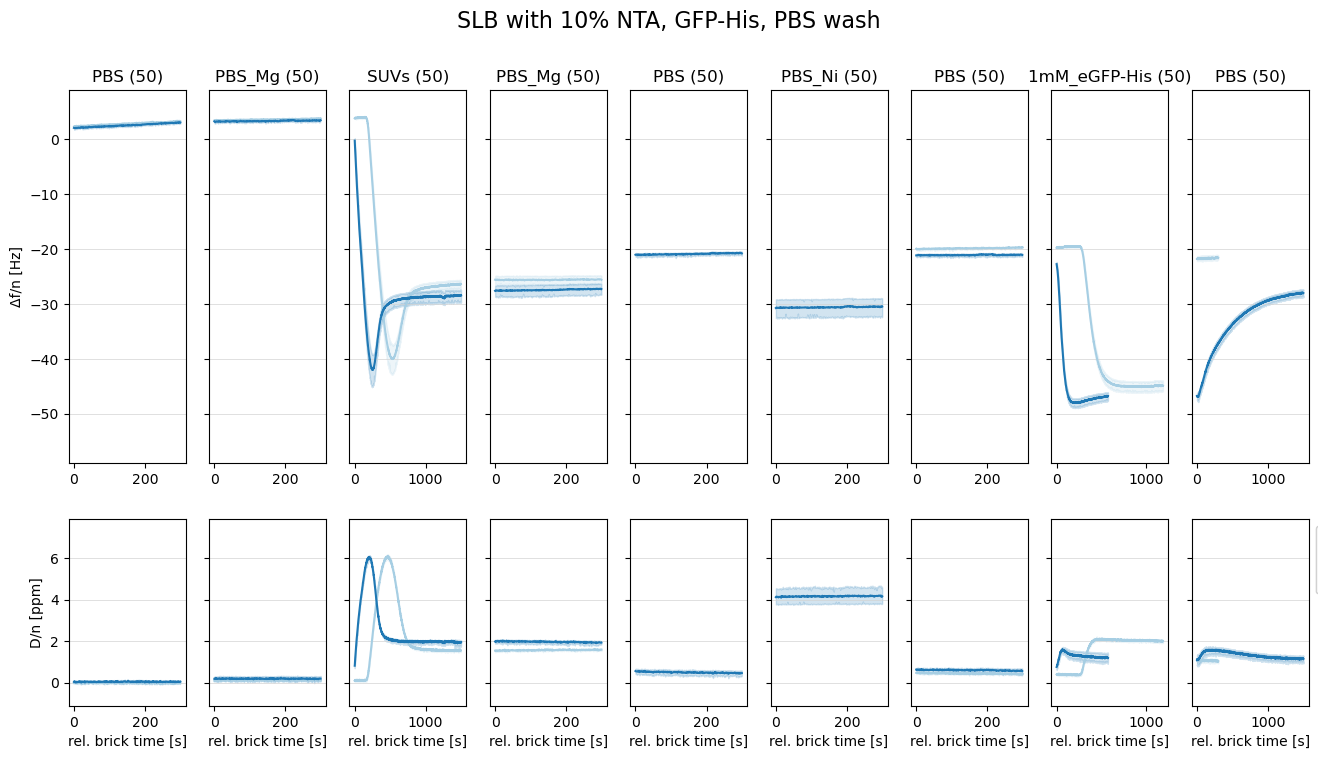

In [5]:


def main():
    
    plotting_info = read_plotting_task(path)

    if plotting_info.empty:
        print("No plotting information available.")
        return

    # Get unique experiment numbers (plot_no)
    unique_experiment_numbers = plotting_info['plot_no'].unique()

    # Iterate through unique experiment numbers
    for plot_no in unique_experiment_numbers:
        
        print(plot_no)
        # Filter plotting_info for the current experiment number
        current_experiment_info = plotting_info[plotting_info['plot_no'] == plot_no]

        # Check if 'brick_plot' is True for any row in the current_experiment_info DataFrame
        if current_experiment_info['brick_plot'].any():
            # Call plot_bricks for the current experiment
            plot_bricks(current_experiment_info, plot_no)
        else:
            print(f"No brick plot indicated for plot No. {plot_no}. Plotting skipped.")


    '''
    # Iterate over experiments and call plot_bricks
    for experiment_number, info in experiments_info.items():
        plot_bricks(experiment_number, info['persistent_ids'], info['bricks_to_plot'], info['title'], info['brick_titles'], info['overtones'], info['max_x'])
    '''

    
   
    '''    
    if not adj_qcmd_data_files:
        print(f"There are no files containing 'adj_qcmd_data.csv' in the folder {path}")
        return
    
    print("Reading in the single sensor data and ensuring that everything is correct")
    
    for i, file in enumerate(adj_qcmd_data_files, start=1):
        print(f"{i}: {file}")
        file_path = os.path.join(path, file)
        
        persistentID, adj_qcmd_pd, adj_qcmd_n7_pd, adj_timeline_pd = process_adj_qcmd_data(file_path)
        print("Opening adj_qcmd_data and adj_timeline for persistent ID: ", persistentID)
        
        # Generate timeline bricks
        timeline_bricks_pd = generate_timeline_bricks(adj_timeline_pd, adj_qcmd_n7_pd)
        
        print("Calculating the bricks from the complete data set")

        # Plot and save complete experiment
        plot_and_save_complete_experiment(adj_qcmd_n7_pd, timeline_bricks_pd, persistentID, path)
        
        # Call the function to select dynamic bricks
        click_flag, selected_bricks = select_dynamic_bricks(timeline_bricks_pd)

        # Process adj_qcmd_bricks
        adj_qcmd_pd, adj_qcmd_bricks_pd = process_adj_qcmd_bricks(timeline_bricks_pd, selected_bricks, adj_qcmd_pd)
        
        mean_brick_pd = mean_value_calc(adj_qcmd_bricks_pd, timeline_bricks_pd)
        
        plot_bricks(timeline_bricks_pd, adj_qcmd_bricks_pd, mean_brick_pd, selected_bricks, persistentID)
        
        # Select Sauerbrey bricks
        click_flag, selected_sauerbrey_bricks = select_sauerbrey_bricks(timeline_bricks_pd)
        
        # Calculate and plot sauerbrey mass
        sauerbrey_detailed_df, sauerbrey_summary_df = calculate_sauerbrey_mass(adj_qcmd_bricks_pd, mean_brick_pd, selected_sauerbrey_bricks)
        plot_and_save_sauerbrey_mass(sauerbrey_detailed_df, sauerbrey_summary_df, persistentID, path)
        
     '''   
        

        

if __name__ == "__main__":
    main()
